# Машинное обучение, ФКН ВШЭ

## Практическое задание 6. Разложение ошибки на смещение и разброс

### Общая информация
Дата выдачи: 20.11.2018

Мягкий дедлайн: 6:00MSK 27.11.2018

Жесткий дедлайн: 23:59MSK 29.11.2018

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-06-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

В этом задании вам предстоит воспользоваться возможностями bootstraping для оценки смещения и разброса алгоритмов машинного обучения. Делать мы это будем на данных boston:

In [29]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor


In [9]:
from sklearn.datasets import load_boston

In [10]:
boston = load_boston()

In [11]:
x_data = boston["data"]
y_data = boston["target"]

In [12]:
x_data.shape, y_data.shape

((506, 13), (506,))

### Вычисление bias и variance с помощью бутстрапа
На лекции была выведено следующая формула, показывающая, как можно представить ошибку алгоритма регрессии в виде суммы трех компонент:
$$
L(\mu) = 
    \mathbb{E}_{x, y}\bigl[\mathbb{E}_{X}\bigl[ (y - \mu(X)(x))^2 \bigr]\bigr] = 
$$
$$
    \underbrace{\mathbb{E}_{x, y}\bigl[(y - \mathbb{E}[y|x] )^2\bigr]}_{\text{шум}} + \underbrace{\mathbb{E}_{x}\bigl[(\mathbb{E}_{X}[\mu(X)(x)] - \mathbb{E}[y|x] )^2\bigr]}_{\text{смещение}} +
    \underbrace{\mathbb{E}_{x}\bigl[\mathbb{E}_{X}\bigl[(\mu(X)(x) - \mathbb{E}_{X}[\mu(X)(x)] )^2\bigr]\bigr]}_{\text{разброс}},
$$
* $\mu(X)$ --- алгоритм, обученный по выборке $X = \{(x_1, y_1), \dots (x_\ell, y_\ell)\}$;
* $\mu(X)(x)$ --- ответ алгоритма, обученного по выборке $X$, на объекте $x$;
* $\mathbb{E}_{X}$ --- мат. ожидание по всем возможным выборкам;
* $\mathbb{E}_{X}[\mu(X)(x)]$ --- "средний" ответ алгоритма, обученного по всем возможным выборкам $X$, на объекте $x$.
    
С помощью этой формулы мы можем анализировать свойства алгоритма обучения модели $\mu$, если зададим вероятностную модель порождения пар $p(x, y)$.

В реальных задачах мы, конечно же, не знаем распределение на парах объект - правильный ответ. Однако у нас есть набор семплов из этого распределения (обучающую выборка), и мы можем использовать его, чтобы оценивать математические ожидания. Для оценки мат. ожиданий по выборкам мы будем пользоваться бутстрэпом - методом генерации "новых" выборок из одной с помощью выбора объектов с возвращением. Разберем несколько шагов на пути к оценке смещения и разброса.

#### Приближенное вычисление интегралов
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar z} f(\bar z)$ функции от многомерной случайной величины $\bar z = (z_1, \dots, z_d)$, $\bar z \sim p(\bar z)$, можно сгенерировать выборку из распределения $p(\bar z)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar z} f(z) = \int f(\bar z) p(\bar z) d \bar z \approx \frac 1 m \sum_{i=1}^m f(\bar z_i), \, \bar z_i \sim p(\bar z), i = 1, \dots, m.$$

Например, оценим $\mathbb{E}_z z^2,$ $z \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_z z^2 = \sigma^2 + \mu^2 = 34$):

In [13]:
z = np.random.normal(loc=5, scale=3, size=1000)
(z**2).mean()

34.02062948557088

#### Оценивание $\mathbb{E}_{x, y}$
Оценить мат. ожидания по $x$ и по $x, y$, встречающиеся во всех трех компонентах разложения, несложно, потому что у нас есть выборка объектов из распределения данных $p(x, y)$:
$$ \mathbb{E}_{x} f(x) \approx \frac 1 N \sum_{i=1}^N f(x_i), \quad
\mathbb{E}_{x, y} f(x, y) \approx \frac 1 N \sum_{i=1}^N f(x_i, y_i),$$
где $N$ - число объектов в выборке, $\{(x_i, y_i)\}_{i=1}^N$ - сама выборка. 

#### Оценивание $\mathbb{E}_X$ с помощью бутстрапа
Чтобы оценить мат. ожидание по $X$, нам понадобится выборка из выборок:
$$\mathbb{E}_X f(X) \approx \frac 1 s \sum_{j=1}^s f(X_j),$$
где $X_j$ - $j$-я выборка. Чтобы их получить, мы можем воспользоваться бутстрапом - методом генерации выборок на основе выбора объектов с возвращением. Чтобы составить одну выборку, будем $N$ раз выбирать индекс объекта $i \sim \text{Uniform}(1 \dots N)$ и добавлять $i$-ю пару (объект, целевая переменная) в выборку. В результате в каждой выборке могут появиться повторяющиеся объекты, а какие-то объекты могут вовсе не войти в некоторые выборки.

#### Итоговый алгоритм оценки смещения и разброса алгоритма $a$
1. Сгенерировать $s$ выборок $X_j$ методом бутстрапа.
1. На каждой выборке $X_j$ обучить алгоритм $a_j$.
1. Для каждой выборки $X_j$ определить множество объектов $T_j$, не вошедших в нее (out-of-bag). Вычислить предсказания алгоритма $a_j$ на объектах $T_j$. 

Поскольку у нас есть только один ответ для каждого объекта, мы будем считать шум равным 0, а $\mathbb{E}[y|x]$ равным имеющемуся правильному ответу для объекта $x$. 

Итоговые оценки:
* Смещение: для одного объекта - квадрат разности среднего предсказания и правильного ответа. Среднее предсказание берется только по тем алгоритмам $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего смещения выполнить усреденение смещений по объектам.
* Разброс: для одного объекта - выборочная дисперсия предсказаний алгоритмов $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего разброса выполнить усреденение разбросов по объектам.
* Ошибка $L$: усреднить квадраты разностей предсказания и правильного ответа по всем выполненным предсказаниям для всех объектов.

В результате должно получиться, что ошибка приблизительно равна сумме смещения и разброса!

Алгоритм также вкратце описан по [ссылке](https://web.engr.oregonstate.edu/~tgd/classes/534/slides/part9.pdf) (слайды 19-21).

__1. (3 балла)__

Реализуйте описанный алгоритм. Обратите внимание, что если объект не вошел ни в одну из out-of-bag выборок, учитывать его в вычислении итоговых величин не нужно. Как обычно, разрешается использовать только один цикл - по выборкам (от 0 до num_runs-1).

In [104]:
def compute_biase_variance(model, x_data, y_data, iteration_count=1000):
    num_objects = len(x_data)
    
    predictions        = np.zeros(num_objects)
    prediction_squares = np.zeros(num_objects)
    prediction_counts  = np.zeros(num_objects)
    
    result_error = 0.0
    for iteration_index in range(iteration_count):
        indexes            = np.random.randint(low=0, high=num_objects, size=num_objects)
        complement_indexes = np.setdiff1d(np.arange(0, num_objects), np.unique(np.sort(indexes)))
        
        model.fit(x_data[indexes], y_data[indexes])
        prediction = model.predict(x_data[complement_indexes])
        
        predictions[complement_indexes]        += prediction
        prediction_squares[complement_indexes] += np.square(prediction)
        result_error                           += np.sum(np.square(prediction - y_data[complement_indexes]))
        
        prediction_counts[complement_indexes] += 1
        
    variance = np.mean(
        (
            prediction_squares[prediction_counts > 0] -
            prediction_counts[prediction_counts > 0] * np.square(
                predictions[prediction_counts > 0] / prediction_counts[prediction_counts > 0]
            )
        )
        / prediction_counts[prediction_counts > 0]
    )
    
    bias = np.mean(
        np.square(
            predictions[prediction_counts > 0] / prediction_counts[prediction_counts > 0] -
            y_data[prediction_counts > 0]
        )
    )
    
    return bias, variance, result_error / np.sum(prediction_counts)
        
    

__2. (0 баллов)__

Оцените смещение, разброс и ошибку для трех алгоритмов с гиперпараметрами по умолчанию: линейная регрессия, решающее дерево, случайный лес.

In [105]:
print('LinearRegression computing result : bias: {0[0]} variance: {0[1]} error: {0[2]}'.format(
          compute_biase_variance(
              LinearRegression(),
              boston['data'],
              boston['target']
          )
    )
)
print('DecisionTreeRegressor computing result : bias: {0[0]} variance: {0[1]} error: {0[2]}'.format(
          compute_biase_variance(
              DecisionTreeRegressor(),
              boston['data'],
              boston['target']
          )
    )
)
print('RandomForestRegressor computing result : bias: {0[0]} variance: {0[1]} error: {0[2]}'.format(
          compute_biase_variance(
              RandomForestRegressor(),
              boston['data'],
              boston['target']
          )
    )
)

LinearRegression computing result : bias: 23.739906369785214 variance: 0.949190128167615 error: 24.750255360756167
DecisionTreeRegressor computing result : bias: 10.217905283449522 variance: 13.025926063799398 error: 23.43398120640661
RandomForestRegressor computing result : bias: 10.69029042909121 variance: 3.374926771192627 error: 14.069076305145407


__3. (1 балл)__
Проанализируйте полученный результат. Согласуются ли полученные результаты с теми, что мы обсуждали на семинарах (с комментарием)?


В проведенном эксперименте можно заметить две вещи, характеризующие качество моделей:
    1. У более простых моделей прослеживается менее выраженная дисперсия. Так, у линейной регрессии она приближенна к единице. У деревьев она намного больше.
    2. У более простых моделей прослеживается более выраженное смещение. Так, у линейной регрессии оно в два раза больше, чем у деревьев.
  
Насколько мне известно, результаты эксперимента согласуются с тем, что мы обсуждали на семинаре.

__3. (1 балл)__
Вспомните обсуждение с лекции о том, во сколько раз в теории бутстрап уменьшает разброс базового алгоритма. Выполняется ли это в ваших экспериментах? Если нет, поясните, почему.

В теории, бустрап уменьшает разброс базового алгоритма в К раз. Но для такого хорошего результата алгоритмы не должны никак кореллировать, что, конечно же, на практике не так. Именно этим и можно объяснить то, что бустрап дал бОльший разброс, чем должен.

### Визуализация предсказаний базовых алгоритмов бэггинга

В материалах лекций можно найти изображение, похожее на мишень - визуализация алгоритмов с разным смещением и разным разбросом. В центре "мишени" - правильный ответ, а "попадания" - предсказания алгоритмов, обученных по разным выборкам. Построим похожее изображение на наших данных для трех алгоритмов. Наши "мишени" будут одномерными, потому что мы решаем задачу одномерной регрессии.

__4. (2 балла)__

Реализуйте фукнцию plot_predictions. Она должна выполнять следующие действия:
1. Случайно выбрать num_test_objects пар объект-целевая переменная из выборки X, y. Получится две выборки: маленькая X_test, y_test (выбранные тестовые объекты) и X_train, y_train (остальные объекты).
1. Сгенерировать num_runs выборок методом бутстарапа из X_train, y_train. На каждой выборке обучить алгоритм regressor и сделать предсказания для X_test.
1. Нарисовать scatter-график. По оси абсцисс - объекты тестовой выборки (номера от 0 до num_test_objects-1), по оси ординат - предсказания. В итоге получится num_test_objects столбиков с точками. Для каждого тестового объекта надо отметить одним цветом все предсказания для него, а также черным цветом отметить правильный ответ.
1. Подпишите оси и название графика (аргумент title).

In [101]:
def split(x_data, y_data, num_test_objects):
    test_indexes  = np.random.choice(len(x_data), num_test_objects, replace=False)
    train_indexes = np.setdiff1d(np.arange(len(x_data)), test_indexes)
    return x_data[train_indexes], y_data[train_indexes], x_data[test_indexes], y_data[test_indexes]

def plot_predictions(model, x_data, y_data, title, num_runs=100, num_test_objects=10):
    plt.xlabel('objects')
    plt.ylabel('model prediction')
    
    x_train, y_train, x_test, y_test = split(x_data, y_data, num_test_objects)
    predictions = np.empty(shape=(num_runs, x_data.shape[0]))
    
    for i in range(num_runs):
        indexes = np.random.randint(low=0, high=len(x_train), size=len(x_train))
        model.fit(x_train[indexes], y_train[indexes])
        plt.scatter(np.arange(num_test_objects), model.predict(x_test), color='orange', alpha=0.2)
        
    plt.scatter(np.arange(num_test_objects), y_test, color='black', label='right prediction')
    plt.legend(title=title)

__5. (0 баллов)__

Нарисуйте графики для линейной регрессии, решающего дерева и случайного леса. Нарисуйте три графика в строчку (это можно сделать с помощью plt.subplot) с одинаковой осью ординат (это важно для понимания масштаба разброса у разных алгоритмов):

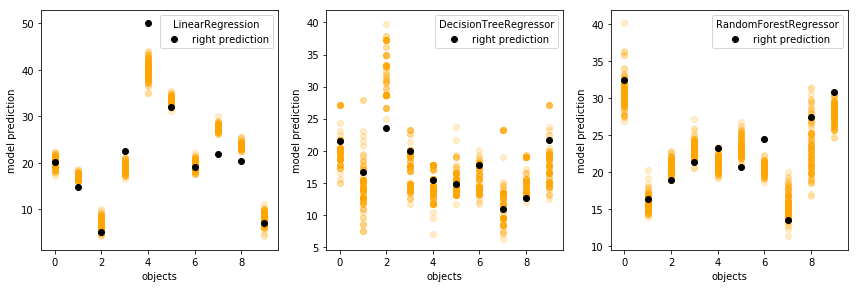

In [103]:
plt.figure(figsize=(40, 15))
plt.subplot(3, 8, 1)
plot_predictions(LinearRegression(), boston['data'], boston['target'], 'LinearRegression')

plt.subplot(3, 8, 2)
plot_predictions(DecisionTreeRegressor(), boston['data'], boston['target'], 'DecisionTreeRegressor')

plt.subplot(3, 8, 3)
plot_predictions(RandomForestRegressor(), boston['data'], boston['target'], 'RandomForestRegressor')

__6. (1 балл)__

Для каждого графика прокомментируйте, как он характеризует смещение и разброс соответствующего алгоритма. 

__Your answer here:__

Как я и говорил выше, для более простых моделей прослеживается менее выраженная дисперсия.
Так, в первом графике явно прослеживается наибольшая кучность точек среди всех трех.
На графике, соответствующем решающему дереву, предсказания распределены намного шире. 
Самый правый график иллюстрирует некоторое среднее значение дисперсии, что согласуется с посчитанным выше.

Аналогичная ситуация со смещением, которое для линейной модели в некоторых случаях принимает достаточно большое значение (например, в 3, 4, 7). На деревьях такие выбросы очень редки, и ими спокойно можно пренебречь.

### Изменение bias и variance при изменении гиперпараметров

__7. (0 баллов)__

Постройте графики зависимости смещения и разброса от гиперпараметров решающего дерева max_depth (от 1 до 10) и max_features (от 1 до X.shape[1]):

In [ ]:
### your code here

__8. (0 баллов)__

Постройте графики зависимости смещения и разброса от n_estimators (по сетке 2**np.arange(1, 10)) для случайного леса и градиентного бустинга:

In [ ]:
### your code here

__3. (2 балла)__

Прокомментируйте графики (всего 4 графика): почему они имеют такой вид.

__Your answer here:__